In [14]:
import numpy as np
import math
import pandas as pd
from geneticalgorithm2 import geneticalgorithm2 as ga

## Leer datos de entrada de producción fotovoltaica

In [15]:
 #read the csv file (put 'r' before the path string to address any special characters in the path, such as '\'). Don't forget to put the file name at the end of the path + ".csv"
produccion_fotovoltaica = pd.read_csv ('Timeseries_38.685_-4.108_SA2_100000kWp_crystSi_14_35deg_-5deg_2019_2019.csv')
df = pd.DataFrame(produccion_fotovoltaica)
print(df)

               time    P  G(i)  H_sun   T2m  WS10m  Int
0     20190101:0010  0.0   0.0    0.0  6.89   0.97  0.0
1     20190101:0110  0.0   0.0    0.0  6.69   0.83  0.0
2     20190101:0210  0.0   0.0    0.0  6.43   0.69  0.0
3     20190101:0310  0.0   0.0    0.0  6.11   0.62  0.0
4     20190101:0410  0.0   0.0    0.0  5.78   0.69  0.0
...             ...  ...   ...    ...   ...    ...  ...
8755  20191231:1910  0.0   0.0    0.0  9.09   0.83  0.0
8756  20191231:2010  0.0   0.0    0.0  7.48   1.10  0.0
8757  20191231:2110  0.0   0.0    0.0  6.02   1.31  0.0
8758  20191231:2210  0.0   0.0    0.0  5.13   1.38  0.0
8759  20191231:2310  0.0   0.0    0.0  5.05   1.24  0.0

[8760 rows x 7 columns]


## Formalización de los periodos horarios

### Representación de una fecha

In [16]:
# cantidad de días que tiene cada mes
DIAS_MES = np.array([31,28,31,30,31,30,31,31,30,31,30,31])
    
# dias del año 2023 que son fin de semana
FINES_SEMANA = np.array([1,7,8,14,15,21,22,28,29,
                         35,36,42,43,49,50,56,57,
                         63,64,70,71,77,78,84,85,
                         91,92,98,99,105,106,112,113,119,120,
                         126,127,133,134,140,141,147,148,
                         154,155,161,162,168,169,175,176,
                         182,183,189,190,196,197,203,204,210,211,
                         217,218,224,225,231,232,238,239,
                         245,246,252,253,259,260,266,267,
                         273,274,280,281,287,288,294,295,301,302,
                         308,309,315,316,322,323,329,330,
                         336,337,343,344,350,351,357,358,364,365])

# dias del año 2023 que son festivos (https://www.calendarr.com/espana/festivos-2023/)
FESTIVOS = np.array([1,6,97,99,121,227,285,305,340,342,359])

from enum import Enum

class Tipo_dia(Enum):
    A = 1
    B = 2
    B1 = 3
    C = 4
    D = 5

class fecha_2023:
    def __init__(self, dia, mes):
        self.dia = dia
        self.mes = mes
    
    def toNumber(self):
        numero = 0
        for i in range(self.mes-1):
            numero += DIAS_MES[i]
        return numero + self.dia
    
    def esFinDeSemana(self):
        return self.toNumber() in FINES_SEMANA
    
    def esFestivo(self):
        return self.toNumber() in FESTIVOS
    
    def esTemporadaAlta(self):
        return (self.mes == 1) or (self.mes == 2) or (self.mes == 7) or (self.mes == 12)
    
    def esTemporadaMediaAlta(self):
        return (self.mes == 3) or (self.mes == 11)
    
    def esTemporadaMedia(self):
        return (self.mes == 6) or (self.mes == 8) or (self.mes == 9)
    
    def esTemporadaBaja(self):
        return (self.mes == 4) or (self.mes == 5) or (self.mes == 10)
    
    def tipo(self):
        if (not self.esFestivo()) and (not self.esFinDeSemana()) and self.esTemporadaAlta():
            return Tipo_dia.A
        elif (not self.esFestivo()) and (not self.esFinDeSemana()) and self.esTemporadaMediaAlta():
            return Tipo_dia.B
        elif (not self.esFestivo()) and (not self.esFinDeSemana()) and self.esTemporadaMedia():
            return Tipo_dia.B1
        elif (not self.esFestivo()) and (not self.esFinDeSemana()) and self.esTemporadaBaja():
            return Tipo_dia.C
        else:
            return Tipo_dia.D

### Formar vector de periodos según las horas del año

In [17]:
periodos_horarios_A  = np.array([6,6,6,6,6,6,6,6,2,1,1,1,1,1,2,2,2,2,1,1,1,1,2,2])
periodos_horarios_B  = np.array([6,6,6,6,6,6,6,6,3,2,2,2,2,2,3,3,3,3,2,2,2,2,3,3])
periodos_horarios_B1 = np.array([6,6,6,6,6,6,6,6,4,3,3,3,3,3,4,4,4,4,3,3,3,3,4,4])
periodos_horarios_C  = np.array([6,6,6,6,6,6,6,6,5,4,4,4,4,4,5,5,5,5,4,4,4,4,5,5])
periodos_horarios_D  = np.array([6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6])

# fecha es un objeto de la clase "fecha_2023" y hora es un entero con valor dentro del rango [0-23]
def periodoHora(fecha,hora):
    if fecha.tipo() == Tipo_dia.A:
        return periodos_horarios_A[hora]
    elif fecha.tipo() == Tipo_dia.B:
        return periodos_horarios_B[hora]
    elif fecha.tipo() == Tipo_dia.B1:
        return periodos_horarios_B1[hora]
    elif fecha.tipo() == Tipo_dia.C:
        return periodos_horarios_C[hora]
    else:
        return periodos_horarios_D[hora]
    

def init_PT(n):
    times_raw = np.array(list(map(lambda a:a.split(":"), df.time.to_numpy())))
    times = np.zeros((n,3), dtype=int)  # [mes, dia, hora]
    for i in range(n):
        times_raw[i][0] = (times_raw[i][0])[4:8]
        times_raw[i][1] = (times_raw[i][1])[0:2]
        
        times[i][0] = (times_raw[i][0])[0:2] # mes
        times[i][1] = (times_raw[i][0])[2:4] # dia
        times[i][2] = times_raw[i][1] # hora
        
    PT = np.zeros(n, dtype=int)
    
    for i in range(n):
        fecha = fecha_2023(times[i][1],times[i][0])
        hora = times[i][2]
        PT[i] = periodoHora(fecha,hora)
    
    return PT

## Constantes

In [18]:
def init_demanda_H2(n):
    regex_h_OctToMar = '[0-9]{4}((0[1-3])|(1[0-2])).*$'
    regex_h_AprToSep = '[0-9]{4}0[4-9].*$'
    index_h_OctToMar = df.index[df.time.str.match(regex_h_OctToMar)].to_numpy()
    index_h_AprToSep = df.index[df.time.str.match(regex_h_AprToSep)].to_numpy()
    
    # first n elements of numpy array
    index_h_OctToMar_n = index_h_OctToMar[:n]
    index_h_AprToSep_n = index_h_AprToSep[:n]
    
    # a = np.zeros(n)
    # if index_h_OctToMar_n[n-1] <= n:
    #     np.put(a, index_h_OctToMar_n, 100)
    # if index_h_AprToSep_n[n-1] <= n:
    #     np.put(a, index_h_AprToSep_n, 150)

    a = np.zeros(n)
    np.put(a, index_h_OctToMar, 100)
    np.put(a, index_h_AprToSep, 150)
    
    return a

In [19]:
# Número total de horas del periodo de cálculo
N_h = 8760
#N_h = 31*24

# Producción eléctrica neta de la instalación fotovoltaica [kWh], >=0.
E_Fv = df[["P"]].to_numpy().ravel()
E_Fv = E_Fv/1000 # pasar a kW

# Potencia máxima de carga/descarga de las baterías [kW]. Igual a la energía máxima que se puede cargar/descargar en una hora [kWh], >=0.
Pmax_Bat = 5000

# Capacidad máxima de almacenamiento de las baterías [kWh], >=0.
Emax_Bat = 20000

# Potencia eléctrica nominal del electrolizador [kW]. Igual al consumo eléctrico nominal durante una hora [kWh], >=0.
Pmax_Ez = 20000

# Ordenada en el origen de la correlación lineal del consumo específico del electrolizador [kWh/ kg H2].
a = 55

# Pendiente de la correlación lineal del consumo específico del electrolizador [kWh/ kg H2].
b = 0.1

# Demanda de hidrógeno de Fertiberia [kg H2], >=0. H2_Dem = 100 (Octubre-Marzo) & = 150 (Abril-Septiembre), en kg H2.
H2_Dem = init_demanda_H2(N_h)

# Capacidad máxima de los tanques de hidrógeno [kg H2], >=0.
H2max_Acu = 6000

# Nivel mínimo de llenado de los tanques de hidrógeno [kg H2], >=0.
H2min_Acu = 0

# Penalización por rotura de stock de H2 [€/kg H2], >=0.
Cesp_noH2 = 1000

# Periodo de las tarifas eléctricas correspondiente a la hora i. Entero de 1 a 6. 
PT = init_PT(N_h)

# Tarifas de compra de electricidad en los periodos P1 a P6 [€/kWh], >=0.
Tc_Ered = 0.001*np.array([280,250,180,150,130,90])

# Tarifas de exportación (venta) de electricidad a la red en los periodos P1 a P6 [€/kWh], >=0.
Texp_Ered = 0.001*np.array([140,130,95,75,70,40])

### Inicialización de variables

In [20]:
########## Inicializar carga de batería y tanques de H2 ##########

# Energía almacenada en las baterías [kWh], >=0. Ed_Bat[0] es la energía inicial en las baterías
Ed_Bat = np.zeros(N_h+1)

# Hidrógeno acumulado en los tanques [kg H2], >=0. H2_Acu[0] es la masa de H2 inicial en los tanques
H2_Acu = np.zeros(N_h+1)


# Energía cargada/descargada en la batería [kWh]. Un valor positivo indica que la batería se descarga y cede energía, mientras que si es negativo la batería se carga y eleva su energía almacenada.
Eint_Bat = np.zeros(N_h)

# Electricidad comprada/exportada a la red general [kWh]. Un valor positivo indica compra de energía de la red y es negativo cuando se exporta energía.
E_Red = np.zeros(N_h)

# Consumo eléctrico bruto del electrolizador [kWh], >=0.
E_Ez = np.zeros(N_h)

# Masa de hidrógeno producido por el electrolizador [kg H2], >=0.
H2_Ez = np.zeros(N_h)

# Diferencia o desvío entre la producción y la demanda de hidrógeno [kg H2]. Positivo si hay más producción y negativo si la demanda es mayor.
H2_Desv = np.zeros(N_h)

# Hidrógeno venteado a la atmósfera [kg H2], >=0.
H2_Vent = np.zeros(N_h)

# Demanda de hidrógeno no cubierta [kg H2], >=0.
H2_noDem = np.zeros(N_h)

# Beneficio económico de la compra/venta de electricidad a red [€]. Valor positivo indica ingresos y negativo costes.
B_Ered = np.zeros(N_h)

## Función objetivo

In [36]:
def f(X):
    
    for i in range(N_h):
        
        ########## Modelo técnico ##########
        
        # Comentar cuando se quieran tener 2 grados de libertad
        X[i*2] = 0
        
        if X[i*2] >= 0:  # batería se descarga
            Eint_Bat[i] = X[i*2]*min(Pmax_Bat,Ed_Bat[i])
        else:  # batería se carga
            Eint_Bat[i] = X[i*2]*min(Pmax_Bat,Emax_Bat-Ed_Bat[i])
        
        Ed_Bat[i+1] = Ed_Bat[i] - Eint_Bat[i]  # balance de la batería
        
        E_Ez[i] = 0.01*X[i*2+1]*Pmax_Ez  # consumo del electrolizador
        
        E_Red[i] = E_Ez[i] - E_Fv[i] - Eint_Bat[i]  # balance eléctrico
        
        H2_Ez[i] = E_Ez[i]/(a+b*X[i*2+1])  # producción de H2
        
        H2_Desv[i] = H2_Ez[i]-H2_Dem[i]  # desvío producción-demanda H2
        
        if (H2_Acu[i] + H2_Desv[i]) > H2max_Acu:  # tanque lleno, venteo
            H2_Acu[i+1] = H2max_Acu
            H2_Vent[i] = H2_Acu[i] + H2_Desv[i] - H2max_Acu
            H2_noDem[i] = 0
        elif (H2_Acu[i] + H2_Desv[i]) < H2min_Acu:  # rotura stock
            H2_Acu[i+1] = 0
            H2_Vent[i] = 0
            H2_noDem[i] = H2min_Acu - (H2_Acu[i] + H2_Desv[i])
        else:  # tanque lleno dentro de rango
            H2_Acu[i+1] = H2_Acu[i] + H2_Desv[i]
            H2_Vent[i] = 0
            H2_noDem[i] = 0
        
        ########## Modelo económico ##########
        
        if E_Red[i] >= 0:  # compra de red, beneficio negativo
            B_Ered[i] = -E_Red[i]*Tc_Ered[PT[i]-1]
        else:  # venta a red, beneficio positivo
            B_Ered[i] = -E_Red[i]*Texp_Ered[PT[i]-1]
    
    
    # Hidrógeno no suministrado a Fertiberia [kg H2], >=0.
    H2tot_noDem = sum(H2_noDem)

    # Beneficio total por compra/venta de luz [€]. Valor positivo indica ingresos y negativo costes.
    Btot_Ered = sum(B_Ered)
    
    F_Obj = Btot_Ered - H2tot_noDem*Cesp_noH2  # valor de la función objetivo
    return -F_Obj

In [37]:
def init_samples(sz, n):
    res = np.zeros((sz, n*2))
    for i in range(sz):
        for j in range(n):
            if (E_Fv[j] > 0) and (PT[j] >= 4):  # hay FV y periodos 4-6 (bajo ingreso)
                res[i][j*2+1] = 100
            else:
                res[i][j*2+1] = 0

            if PT[j] == 6:
                res[i][j*2] = -1  # batería se carga en P6
            elif PT[j] == 1:
                res[i][j*2] = 1  # batería se descarga en P1
            else:
                res[i][j*2] = 0
    
    return res
            
    


First scores are made from gotten variables (by 6.754199028015137 secs, about 0.06754199028015137 for each creature)

Best score before optimization: 334696014.6638459
                                                                                                                                                                                                        
 The best found solution:
 [ 0. 83.  0. ...  1.  0. 26.]

 Objective function:
 -5911026.040000003

 Used generations: 200
 Used time: 1.11e+03 seconds


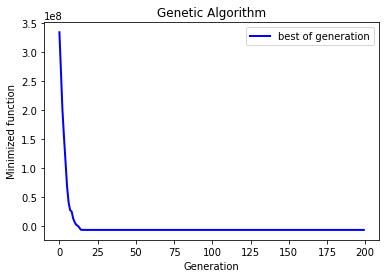

GAResult(last_generation=Generation(variables=array([[ 0., 83.,  0., ...,  1.,  0., 26.],
       [ 0., 68.,  0., ...,  1.,  0., 26.],
       [ 0., 83.,  0., ...,  1.,  0., 26.],
       ...,
       [ 0., 83.,  0., ..., 19.,  0., 36.],
       [ 0., 19.,  0., ...,  2.,  0., 26.],
       [ 0., 48.,  0., ..., 19.,  0., 26.]]), scores=array([-5911026.04      , -5714988.785     , -5625862.41500001,
       -5612727.72500001, -5569980.31500001, -5556273.76      ,
       -5548800.41      , -5516569.71500001, -5506367.885     ,
       -5505281.67      , -5501030.93500001, -5499557.46000001,
       -5480825.97500001, -5479888.735     , -5471613.65000001,
       -5468378.71      , -5465753.18      , -5434504.95500001,
       -5430915.82      , -5426691.14500001, -5420941.75000001,
       -5419444.905     , -5419202.48500001, -5413176.55000001,
       -5410111.47500001, -5405958.75000001, -5400121.25544013,
       -5394570.23000001, -5392989.085     , -5387388.305     ,
       -5386509.26000001, -53

In [43]:
#from DiscreteHillClimbing import Hill_Climbing_descent
from geneticalgorithm2 import Population_initializer

'''Gc_Bat(i): potencia de carga/descarga de trabajo de las baterías, normalizada respecto al máximo valor posible 
    (‘Pmax_Bat’ o según las limitaciones existentes para la carga o descarga completa de la batería). Su valor se
    sitúa en el rango [-1, 1] de modo que cuando adquiere valor nulo la batería ni se carga ni se descarga;
    -1 representa carga máxima y 1 descarga. Se admiten valores intermedios. [Adimensional]'''

'''Gc_Ez(i): grado de carga del electrolizador. [Adimensional]. Rango [0-100].'''

population_size = 100

algorithm_param = {'max_num_iteration': 200,\
                   'population_size': population_size,\
                   'mutation_probability':0.1,\
                   'elit_ratio': 0.01,\
                   'parents_portion': 0.3,\
                   'crossover_type':'one_point',\
                   'max_iteration_without_improv': 200}

varbound=[[-1,1],[0,100]]*N_h

vartype = (('real','int'))*N_h

model=ga(function=f,dimension=N_h*2,variable_type=vartype,variable_boundaries=varbound, algorithm_parameters=algorithm_param)

# INICIALIZACIÓN A 0
#samples = np.zeros((population_size, N_h*2))

# INICIALIZACIÓN CON SOLUCIÓN INICIAL RAZONABLE
samples = init_samples(population_size, N_h)

model.run(start_generation={'variables':samples, 'scores': None})